In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.phenotype import convert_to_phen

from test_phenotype_sim.phenotype_test import test_variance


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 -t 2 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = 0.0  
var_1 = 1.0  
model_normal = grg_causal_mutation_model("normal", mean=mean_1, var=var_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [-0.8057323  -0.08381501 -0.7100795  -1.4247588  -0.53162844 -0.99228445
  0.20834506  0.32214809  1.18831928 -0.13085154  0.35491048  0.19279338
 -0.50006467 -1.21744527 -1.66326355  0.86730133  0.95226934  1.81472466
 -1.13895365 -0.15894813 -0.94472539  1.14408633  0.97649783  0.48981163
  0.39143243  0.39029333  1.45945704  1.96845676  0.07896871  0.89533858
 -1.3427018  -0.81859292  0.11131621  1.32617818 -0.7092675   0.5724293
 -0.39183771  0.16742985 -0.6479582  -0.40782306  0.42037027 -0.60220566
 -0.01319145 -1.63032987 -1.30911343  0.53770205 -0.47322084  0.93227113
 -1.21880125  0.28364642 -0.35310768 -1.81990898  0.19530062  0.35229783
  0.28723955 -0.76929829 -2.06455466  1.89888249  0.9760416  -0.87943229
 -0.85953767  0.58371263  0.78904384  0.31466817  1.04198806  0.48561901
 -0.28446309 -1.23636947  0.39223759  2.61207027  0.27013433  0.20269328
 -0.02751533  0.62023054  0.35865418  1.7733767  -0.14642128  1.69563807
  1.41570489  2.18452166  0.

In [5]:

trait_df_normal = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal, random_seed=1)
sample_nodes_df = additive_effect_sizes(grg_1, trait_df_normal)

In [6]:
individual_genetic_value_df = samples_to_individuals(sample_nodes_df) #non-normalized genetic value df
individual_genetic_value_df

,individual_id,genetic_value,causal_mutation_id
0,0,-16.501664,0
1,1,-2.454348,0
2,2,-17.303803,0
3,3,6.641214,0
4,4,-8.710213,0
...,...,...,...
195,195,12.536488,0
196,196,16.549154,0
197,197,5.463626,0
198,198,-0.663779,0


We first show how to simulate environmental noise before the genetic values have been normalized, with a narrow-sense heritability of 0.5.

In [7]:
phenotypes = sim_env_noise(individual_genetic_value_df, h2=0.5) #simulating environmental noise without normalizing genetic values
phenotype_df = phenotypes.phenotype_df
phenotype_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,15.534603,-0.967061
1,0,1,-2.454348,-4.908917,-7.363265
2,0,2,-17.303803,-19.082846,-36.386649
3,0,3,6.641214,-16.995070,-10.353857
4,0,4,-8.710213,0.026013,-8.684199
...,...,...,...,...,...
195,0,195,12.536488,-6.249272,6.287217
196,0,196,16.549154,-6.884718,9.664436
197,0,197,5.463626,23.772076,29.235702
198,0,198,-0.663779,-3.690030,-4.353809


In [8]:
h2_used = phenotypes.get_h2() #showing the h2 factor used, can be acccessed since it is a class attribute of phenotypes
print(h2_used)

[0.5]


In [9]:
phenotype_df = normalize(phenotypes)
test1 = test_variance(phenotype_df)
print("Variance of the phenotypes is " + str(phenotype_df['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df['environmental_noise'].var()))
print(test1)   #tests the variance condition in the phenotypic data, expected value close to zero
phenotype_df

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.4884356187615832
Variance of the noise is 0.5231732823295588
-0.011608901091141988


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.262478,0.901875,0.639397
1,0,1,0.479702,-0.178244,0.301458
2,0,2,-0.304858,-0.927114,-1.231972
3,0,3,0.960260,-0.816808,0.143452
4,0,4,0.149178,0.082489,0.231667
...,...,...,...,...,...
195,0,195,1.271733,-0.249061,1.022672
196,0,196,1.483739,-0.282634,1.201105
197,0,197,0.898043,1.337096,2.235139
198,0,198,0.574306,-0.113845,0.460461


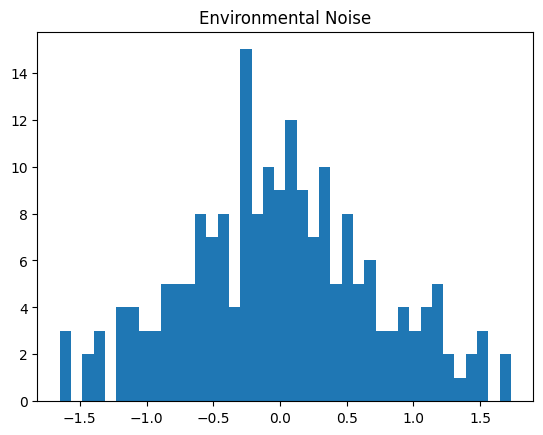

Mean of noise: 2.6645352591003756e-17
Standard deviation of noise: 0.7233071839333264


In [10]:

plt.hist(phenotype_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df['environmental_noise'].std()))

Now, we show a sample where zero noise is simulated (h2=1) by default.

In [11]:
phenotypes_zero_noise = sim_env_noise(individual_genetic_value_df) #simulating environmental noise without normalizing genetic values
phenotype_df_zero_noise = phenotypes_zero_noise.phenotype_df
phenotype_df_zero_noise

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-16.501664
1,0,1,-2.454348,0.0,-2.454348
2,0,2,-17.303803,0.0,-17.303803
3,0,3,6.641214,0.0,6.641214
4,0,4,-8.710213,0.0,-8.710213
...,...,...,...,...,...
195,0,195,12.536488,0.0,12.536488
196,0,196,16.549154,0.0,16.549154
197,0,197,5.463626,0.0,5.463626
198,0,198,-0.663779,0.0,-0.663779


In [12]:
phenotype_df_zero_noise = normalize(phenotypes_zero_noise)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise['environmental_noise'].var()))
phenotype_df_zero_noise

Variance of the phenotypes is 0.9999999999999997
Variance of the genetic values is 174.97473363027564
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-0.375568
1,0,1,-2.454348,0.0,0.686386
2,0,2,-17.303803,0.0,-0.436209
3,0,3,6.641214,0.0,1.373995
4,0,4,-8.710213,0.0,0.213453
...,...,...,...,...,...
195,0,195,12.536488,0.0,1.819668
196,0,196,16.549154,0.0,2.123019
197,0,197,5.463626,0.0,1.284972
198,0,198,-0.663779,0.0,0.821750


In [13]:
phenotype_df_zero_noise_genetic_normalize = normalize(phenotypes_zero_noise, normalize_genetic_values=True)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise_genetic_normalize['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise_genetic_normalize['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise_genetic_normalize['environmental_noise'].var()))
phenotype_df_zero_noise_genetic_normalize


Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.9999999999999997
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.0,-0.375568
1,0,1,0.686386,0.0,0.686386
2,0,2,-0.436209,0.0,-0.436209
3,0,3,1.373995,0.0,1.373995
4,0,4,0.213453,0.0,0.213453
...,...,...,...,...,...
195,0,195,1.819668,0.0,1.819668
196,0,196,2.123019,0.0,2.123019
197,0,197,1.284972,0.0,1.284972
198,0,198,0.821750,0.0,0.821750


Now, we simulate environmental noise before the genetic values have been normalized, with user defined noise. If user_defined is set to True, the user must specify mean and std values to be simulated from.

In [14]:
phenotype_non_normalized_user_defined = sim_env_noise(individual_genetic_value_df, user_defined=True, mean=0, std=1) #simulating standard noise on the non-normalized genetic values
phenotype_df_non_normalized_user_defined = phenotype_non_normalized_user_defined.phenotype_df
phenotype_df_non_normalized_user_defined

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.241220,-16.260443
1,0,1,-2.454348,0.683264,-1.771084
2,0,2,-17.303803,1.076311,-16.227492
3,0,3,6.641214,0.399259,7.040473
4,0,4,-8.710213,0.864785,-7.845427
...,...,...,...,...,...
195,0,195,12.536488,-1.778189,10.758300
196,0,196,16.549154,-0.620057,15.929097
197,0,197,5.463626,-1.317306,4.146319
198,0,198,-0.663779,0.191689,-0.472090


The user can choose to view the h2 narrow sense heritability factor for the user-defined noise as well.

In [15]:
h2_user_defined = phenotype_non_normalized_user_defined.get_h2()
print(h2_user_defined)

1.014513875372244


In [16]:
phenotype_df_non_normalized_user_defined = normalize(phenotype_non_normalized_user_defined)
print("Variance of the phenotypes is " + str(phenotype_df_non_normalized_user_defined['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_non_normalized_user_defined['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].var()))
phenotype_df_non_normalized_user_defined

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 1.0084468910626865
Variance of the noise is 0.006066984309557704


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.377151,0.018020,-0.359131
1,0,1,0.689279,0.051578,0.740857
2,0,2,-0.438047,0.081417,-0.356630
3,0,3,1.379786,0.030018,1.409804
4,0,4,0.214352,0.065359,0.279711
...,...,...,...,...,...
195,0,195,1.827337,-0.135288,1.692050
196,0,196,2.131967,-0.047366,2.084601
197,0,197,1.290387,-0.100299,1.190088
198,0,198,0.825213,0.014260,0.839473


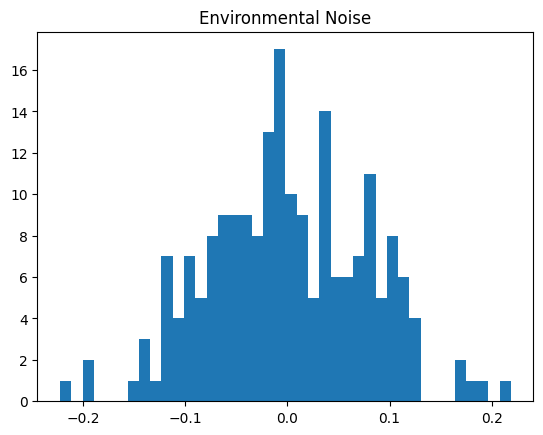

Mean of noise: 1.1102230246251566e-18
Standard deviation of noise: 0.07789084868941733


In [17]:

plt.hist(phenotype_df_non_normalized_user_defined["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].std()))

The user could also define a custom distribution to simulate environmental noise from.

In [18]:
genetic_val_df_normalized = normalize_genetic_values(individual_genetic_value_df) #normalized genetic value df
genetic_val_df_normalized

,individual_id,genetic_value,causal_mutation_id
0,0,-0.375568,0
1,1,0.686386,0
2,2,-0.436209,0
3,3,1.373995,0
4,4,0.213453,0
...,...,...,...
195,195,1.819668,0
196,196,2.123019,0
197,197,1.284972,0
198,198,0.821750,0


We now show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 0.25.

In [19]:
phenotype_post_normalization_h2 = sim_env_noise(genetic_val_df_normalized, h2=0.25) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization_h2 = phenotype_post_normalization_h2.phenotype_df
phenotype_df_post_normalization_h2

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,1.601558,1.225990
1,0,1,0.686386,0.682472,1.368858
2,0,2,-0.436209,-0.465977,-0.902185
3,0,3,1.373995,2.163896,3.537891
4,0,4,0.213453,-1.026266,-0.812814
...,...,...,...,...,...
195,0,195,1.819668,1.308226,3.127894
196,0,196,2.123019,-0.928344,1.194675
197,0,197,1.284972,-1.445984,-0.161012
198,0,198,0.821750,-1.918039,-1.096289


In [20]:
phenotype_df_post_normalization_h2 = normalize(phenotype_post_normalization_h2)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_h2['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_h2['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_h2['environmental_noise'].var()))
test3 = test_variance(phenotype_df_post_normalization_h2)
print(test3)  #tests the variance condition in the phenotypic data, expected value is close to zero
phenotype_df_post_normalization_h2

Variance of the phenotypes is 0.9999999999999999
Variance of the genetic values is 0.29806953666272573
Variance of the noise is 0.8465203371405703
-0.14458987380329613


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.205044,0.860080,0.655036
1,0,1,0.374737,0.358298,0.733036
2,0,2,-0.238151,-0.268706,-0.506857
3,0,3,0.750143,1.167093,1.917236
4,0,4,0.116536,-0.574600,-0.458064
...,...,...,...,...,...
195,0,195,0.993461,0.699933,1.693395
196,0,196,1.159078,-0.521138,0.637940
197,0,197,0.701540,-0.803748,-0.102208
198,0,198,0.448640,-1.061470,-0.612830


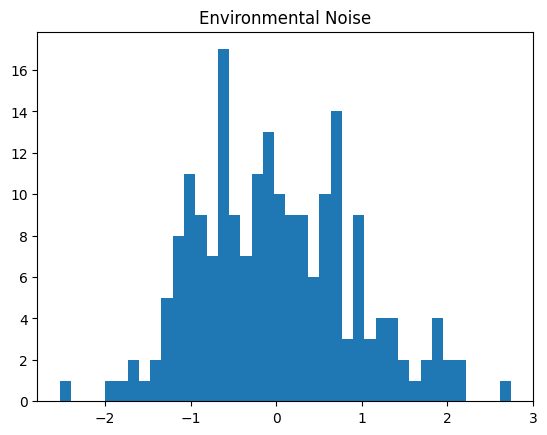

Mean of noise: 2.2204460492503132e-17
Standard deviation of noise: 0.9200653982954529


In [21]:

plt.hist(phenotype_df_post_normalization_h2["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].std()))

We finally show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 1 (default case) and user defined cases for the noise.

In [22]:
phenotype_post_normalization_default_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=0, std=1) #simulating noise after genetic values have been normalized with h2=1 and user defined with standard mean and std
phenotype_df_post_normalization_default_mean_and_std = phenotype_post_normalization_default_mean_and_std.phenotype_df
phenotype_df_post_normalization_default_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,-0.406794,-0.782362
1,0,1,0.686386,-0.412968,0.273418
2,0,2,-0.436209,0.996197,0.559988
3,0,3,1.373995,0.851554,2.225550
4,0,4,0.213453,0.295502,0.508955
...,...,...,...,...,...
195,0,195,1.819668,-0.994537,0.825131
196,0,196,2.123019,0.311808,2.434827
197,0,197,1.284972,1.109993,2.394965
198,0,198,0.821750,0.708668,1.530418


In [23]:
phenotype_df_post_normalization_default_mean_and_std = normalize(phenotype_post_normalization_default_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_default_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_default_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].var()))
phenotype_df_post_normalization_default_mean_and_std

Variance of the phenotypes is 0.9999999999999999
Variance of the genetic values is 0.47803113231098543
Variance of the noise is 0.508621077299177


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.259667,-0.255844,-0.515511
1,0,1,0.474566,-0.260113,0.214453
2,0,2,-0.301594,0.714181,0.412587
3,0,3,0.949978,0.614175,1.564153
4,0,4,0.147581,0.229722,0.377303
...,...,...,...,...,...
195,0,195,1.258115,-0.662209,0.595906
196,0,196,1.467851,0.240996,1.708847
197,0,197,0.888427,0.792859,1.681286
198,0,198,0.568156,0.515384,1.083540


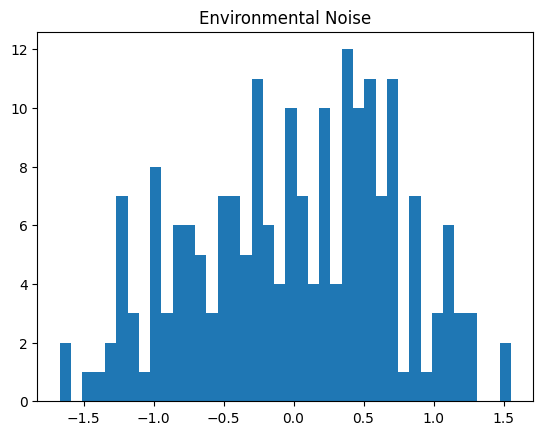

Mean of noise: -8.881784197001253e-18
Standard deviation of noise: 0.7131767503916382


In [24]:

plt.hist(phenotype_df_post_normalization_default_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_unique_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=1, std=2) #simulating noise after genetic values have been normalized with h2=1 and user defined mean and std
phenotype_df_post_normalization_unique_mean_and_std = phenotype_post_normalization_unique_mean_and_std.phenotype_df
phenotype_df_post_normalization_unique_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,1.546549,1.170981
1,0,1,0.686386,-0.501826,0.184560
2,0,2,-0.436209,0.580732,0.144523
3,0,3,1.373995,3.518505,4.892500
4,0,4,0.213453,5.914954,6.128407
...,...,...,...,...,...
195,0,195,1.819668,0.599874,2.419542
196,0,196,2.123019,-2.788736,-0.665716
197,0,197,1.284972,3.230055,4.515027
198,0,198,0.821750,-2.757022,-1.935272


In [26]:
phenotype_df_post_normalization_unique_mean_and_std = normalize(phenotype_post_normalization_unique_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_unique_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_unique_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].var()))
test5 = test_variance(phenotype_df_post_normalization_unique_mean_and_std)
phenotype_df_post_normalization_unique_mean_and_std

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.20153900802093513
Variance of the noise is 0.8554292342442482


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.168604,0.215921,0.047316
1,0,1,0.308140,-0.703659,-0.395519
2,0,2,-0.195828,-0.217665,-0.413492
3,0,3,0.616829,1.101193,1.718022
4,0,4,0.095826,2.177033,2.272859
...,...,...,...,...,...
195,0,195,0.816905,-0.209071,0.607834
196,0,196,0.953089,-1.730323,-0.777234
197,0,197,0.576864,0.971698,1.548562
198,0,198,0.368909,-1.716086,-1.347177


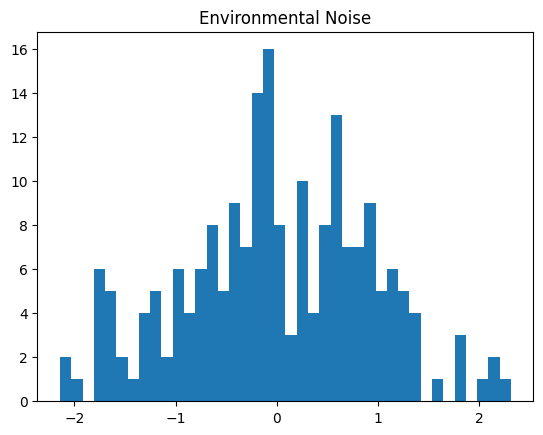

Mean of noise: 2.2204460492503132e-17
Standard deviation of noise: 0.924894174619047


In [27]:

plt.hist(phenotype_df_post_normalization_unique_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].std()))

We show an example of converting the final phenotypes output to a standard .phen file format to be saved in the local directory.

In [28]:
local_path = 'post_noise_phenotypes.phen' #will be saved in a .phen file of this name in the local directory.
convert_to_phen(phenotype_df_post_normalization_unique_mean_and_std, local_path, include_header=True)